 ## Autoencoder example version 2

In [1]:
import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True) # 1 is enough for testing :)

In [4]:
#Autoencoder class
class autoenc(nn.Module):
  
    def __init__(self, n_in, n_hid, n_out):
        super(autoenc, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(n_in, n_hid), # 784*128, 128*64
                                     nn.ReLU(), 
                                     nn.Linear(n_hid, n_out), 
                                     nn.ReLU()
                                     ) 
        self.decoder = nn.Sequential(nn.Linear(n_out, n_hid), #64*128 128*784
                                      nn.ReLU(), 
                                      nn.Linear(n_hid, n_in), 
                                      nn.Sigmoid()
                                      )
    
    def forward(self, X):
      x = X.view(X.size(0), -1)      
      enc = self.encoder(x)
      dec = self.decoder(enc)
      return dec

In [5]:
#loss by points
def loss_func(pred, target):
    return F.binary_cross_entropy(pred, target)

In [6]:
lr = 0.1
epochs = 10

In [7]:
def train(network, train_loader, lr, loss_func, epochs):
    optimizer = torch.optim.SGD(network.parameters(), lr=lr) #stochastic gradient descent optimizer
    for epoch in range(epochs):
      for X, y in train_loader: #y - picture labels
        network.zero_grad()
        prediction = network(X)
        loss = loss_func(prediction, X.detach().view(X.size(0), -1)) #compute loss
        loss.backward() #backprop
        optimizer.step()
      print("EPOCH: {}, LOSS: {}".format(epoch, loss)) 

In [8]:
#n_in - input dimension, #n_hid - hidden dimension, #n_out - encoding dimension
automodel = autoenc(784, 128, 64)

In [9]:
train(automodel, train_loader, lr, loss_func, epochs)

EPOCH: 0, LOSS: -29.65262794494629
EPOCH: 1, LOSS: -35.4289436340332
EPOCH: 2, LOSS: -40.76417922973633
EPOCH: 3, LOSS: -40.225791931152344
EPOCH: 4, LOSS: -40.65572738647461
EPOCH: 5, LOSS: -42.115394592285156
EPOCH: 6, LOSS: -44.90922927856445
EPOCH: 7, LOSS: -43.33097457885742
EPOCH: 8, LOSS: -47.417137145996094
EPOCH: 9, LOSS: -46.68494415283203


In [10]:
# some tests
min_loss = -100000
max_loss = 100000
abs_loss = 100000

for X, y in test_loader: # y-label are 
  with torch.no_grad():
    preds = automodel(X)
    loss = loss_func(preds, X.view(X.size(0), -1))

    if loss.detach()>min_loss:
      min_loss = loss
      orig1 = X.detach().numpy().reshape(28,28)
      decd1 = preds.detach().numpy().reshape(28,28)

    if loss.detach()<max_loss:
      max_loss = loss
      orig2 = X.detach().numpy().reshape(28,28)
      decd2 = preds.detach().numpy().reshape(28,28)

    if abs(loss.detach())<abs_loss: # best picture
      abs_loss = loss
      orig3 = X.detach().numpy().reshape(28,28)
      decd3 = preds.detach().numpy().reshape(28,28)

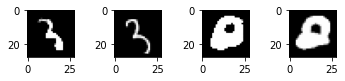

In [11]:
#the worst pictures
plt.subplot(4, 4, 1)
plt.imshow(decd1, cmap=plt.cm.Greys_r)
plt.subplot(4, 4, 2)
plt.imshow(orig1, cmap=plt.cm.Greys_r)

plt.subplot(4, 4, 3)
plt.imshow(decd2, cmap=plt.cm.Greys_r)
plt.subplot(4, 4, 4)
plt.imshow(orig2, cmap=plt.cm.Greys_r)

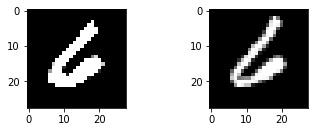

In [12]:
#the best one
plt.subplot(2, 2, 1)
plt.imshow(decd3, cmap=plt.cm.Greys_r)
plt.subplot(2, 2, 2)
plt.imshow(orig3, cmap=plt.cm.Greys_r)

### вопросы

- в трейне учиться восстанавливать X по шумной картинке, то есть отдавать модели не X в некой строчке, а шумный X

будьте внимательны! X - это тензор

- поэкспериментировать с размерностью скрытого пространства: можно ли, например, закодировать картинку 5 числами? 1000? что получится? найдите это место в коде, поменяйте и проверьте

- узнайте, что такое binary_cross_entropy. Почему мы используем ее в качестве функции потерь? что такое "потеря" в нашем случае?